<a href="https://colab.research.google.com/github/kumar-selvakumaran/pytorch_training/blob/main/NN_toys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Notes:</h1>
<h3><ol><li>pytorch forum says to alter parameters manually only with torch.no_grad():, but tried doing it without. : <a href="https://discuss.pytorch.org/t/how-to-manually-set-the-weights-in-a-two-layer-linear-model/45902">link</a><br><br> dosent work : <br>error :

```
RuntimeError                              Traceback (most recent call last)

<ipython-input-160-fbab85b2caea> in <cell line: 1>()
----> 1 modelpart.get_parameter("layer.weight")[0][0][0,1] = 0
      2
      3 # print_pars(modelpart)

RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.
```
works only with torch.no_grad():<br>
maybe related to doing because its not recommended to do inplace opertaions as read in the documentation</li>
<li> when using multiple loss functions, to back propogate on each of them, you can just add each of the component losses to make a final loss, and do a final_loss.backward(); optimizer.step(). and this updates all the parameters according to how they contribute to each of these losses. i.e. as intended.

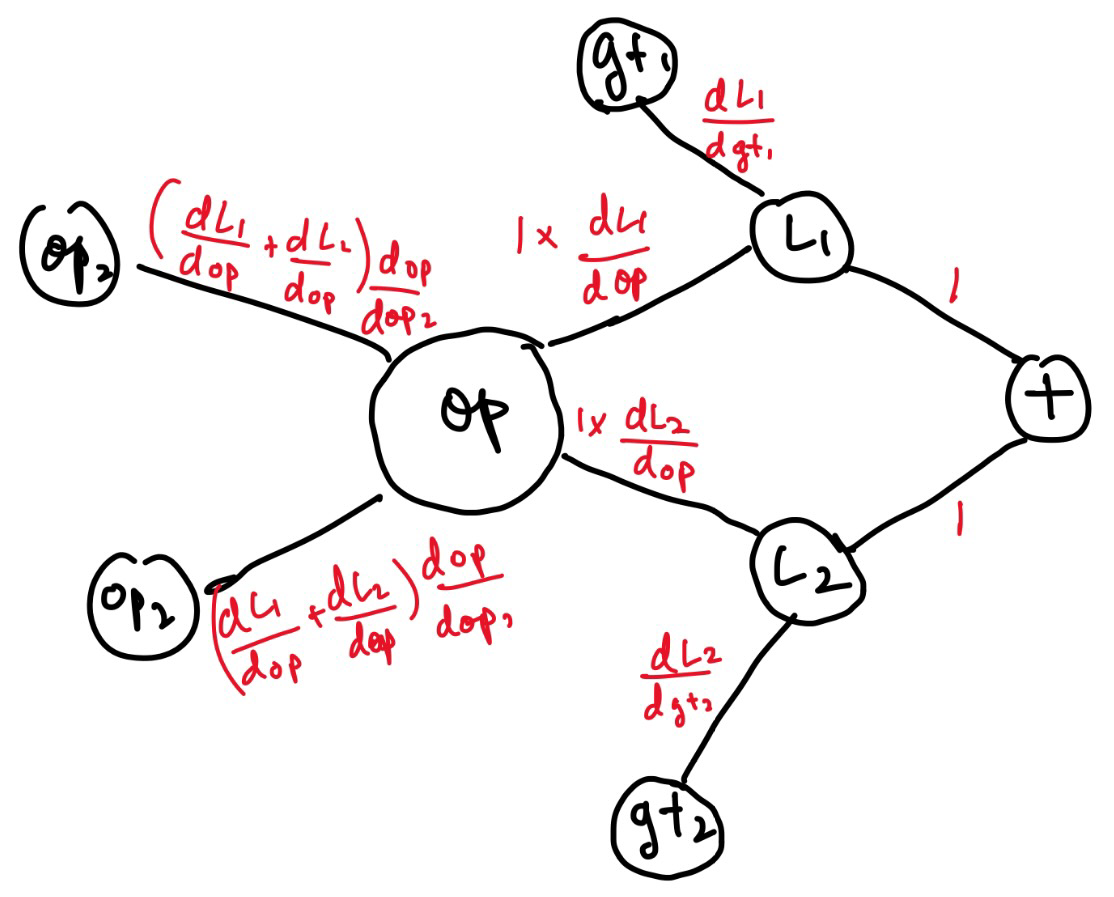


In [ ]:
#helper functions KEEP
def print_pars(model):
  named_pars = tuple(model.named_parameters())
  print(f"parameters are as follows :")
  for ind, i in enumerate(named_pars):
    print(f"\nparameter : {ind+1} : \n\nname : {i[0]}\n\nparameters : {i[1]}\n\ngradients : {i[1].grad}")


<h3> Experiment 1: multiple heads, and loss functions </h3>

In [ ]:
import torch
from torch import nn


class convlayer(nn.Module):
  def __init__(self):
    super(convlayer, self).__init__()
    self.layer = nn.Conv2d(in_channels = 1,
                           out_channels = 1,
                           kernel_size = 2)
  def forward(self, x):
    return self.layer(x)


class toynn(nn.Module):
  def __init__(self):
    super().__init__()

    conv1 = convlayer()
    self.conv1 = conv1

    leaf1 = convlayer()
    self.leaf1 = leaf1

    leaf2 = convlayer()
    self.leaf2 = leaf2

  def forward(self, x):
    x = self.conv1(x)
    x1 = self.leaf1(x)
    x2 = self.leaf2(x)
    ypred = torch.cat((x1, x2), axis = 0)
    return ypred



x = torch.ones((1,3,3))
model = toynn()

with torch.no_grad():
  model.get_parameter("leaf1.layer.weight")[0][0][0,0] = 1
  model.get_parameter("leaf1.layer.bias")[0] = 0
  model.get_parameter("leaf1.layer.weight")[0][0][1,0] = 1
  model.get_parameter("leaf1.layer.weight")[0][0][0,1] = 1
  model.get_parameter("leaf1.layer.weight")[0][0][1,1] = 1

  model.get_parameter("leaf2.layer.weight")[0][0][0,0] = 1
  model.get_parameter("leaf2.layer.bias")[0] = 0
  model.get_parameter("leaf2.layer.weight")[0][0][1,0] = 1
  model.get_parameter("leaf2.layer.weight")[0][0][0,1] = 1
  model.get_parameter("leaf2.layer.weight")[0][0][1,1] = 1




  model.get_parameter("conv1.layer.weight")[0][0][0,0] = 1
  model.get_parameter("conv1.layer.bias")[0] = 0
  model.get_parameter("conv1.layer.weight")[0][0][1,0] = 1
  model.get_parameter("conv1.layer.weight")[0][0][0,1] = 1
  model.get_parameter("conv1.layer.weight")[0][0][1,1] = 1

y = model(x)
print(y)

def ownloss(gt, pred):
  return gt - pred
print_pars(model)

def ownloss2(gt, pred):
  return -(gt @ pred)
print_pars(model)

loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1)

model.train()

gt = torch.tensor([[[17.0]], [[2.0]]])
gt.requires_grad = True

lossval1 = ownloss(gt[0],y[0])
lossval2 = ownloss2(gt[1],y[1])
# lossval1.backward(retain_graph = True)
# lossval2.backward()
lv = lossval1+lossval2
lv.backward()
optimizer.step()
print_pars(model)


<h3>Experiment weqe